In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
import statistics
from matplotlib.patches import FancyArrow
import json
import textstat
import re
import math


plt.rcParams['figure.dpi'] = 100

# 将X/Y轴的刻度线方向设置向内
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 设置字体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Microsoft Yahei'

# 设置公式字体
config = {
    "mathtext.fontset": 'stix',
}
rcParams.update(config)


def get_score_gap(filepath, index):
    elements = []
    with open(filepath, 'r', encoding='utf-8') as file:
        elements = json.load(file)
    file.close()
    return elements[index]

def regular_data(data):
    min_value = min(data)
    max_value = max(data)
    normalized_data = [(x - min_value) / (max_value - min_value) for x in data]
    return normalized_data

def clean_deviation(original_dict):
    # 提取值列表
    keys = list(original_dict.keys())
    values = list(original_dict.values())
    # 计算值的标准差和均值
    std_dev = np.std(values)
    mean_value = np.mean(values)
    # 计算每个值与均值的偏离程度
    deviation = np.abs(values - mean_value)
    # 移除偏离程度超过2倍标准差的数据点
    filtered_indices = [i for i, dev in enumerate(deviation) if dev <= 2*std_dev]
    filtered_dict = {}
    for i in filtered_indices:
        filtered_dict[keys[i]] = values[i]
    return filtered_dict

# Michel 2007 计算频区间的中心值
def get_center_value(freqs):
    maxi = np.log10(max(freqs))
    minu = np.log10(min(freqs))
    center = (maxi + minu) / 2  # logarithmic mean 对数均值
    return 10**center


# 计算置信区间
def get_confidence_interval(data, confidence_level):
    n = len(data)  # 样本大小
    mean = np.mean(data)  # 样本均值
    std_err = stats.sem(data)  # 样本标准误差
    # 使用 t 分布计算置信区间（适用于样本较小的情况）
    t_value = stats.t.ppf((1 + confidence_level) / 2, df=n-1)  # t 分布临界值
    margin_of_error = t_value * std_err  # 误差范围
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)  # 置信区间
    return confidence_interval


def distance_to_line(point_x, point_y):
    distance = math.fabs(point_y - point_x) / math.sqrt(2)
    return distance


# 词组对应的频率
def get_frequency_in_C4EL():           
    # 获取词组的出现次数
    appear_times_in_C4EL = {}
    df_appear_times = pd.read_csv('data/data analysis v2.0/latin phrase in data v1.0.csv')
    for pha, appear_times in zip(df_appear_times['phrase'], df_appear_times['appear times']):
        appear_times_in_C4EL[pha] = appear_times
    
    total_wards_in_LE = 474105865
    dict_frequency = {}
    # 获取频率数据
    for pha, times in appear_times_in_C4EL.items():
        freq = times / total_wards_in_LE
        dict_frequency[pha] = freq
    return dict_frequency


In [9]:
modelx = 'mixtral'
modely = 'llama3'

file_modelx = 'data\llm2.1.2\sbert\score-gap\LE-dataset v2.0-150-'+ modelx +'-score-gap v2.1.2.json'
file_modely = 'data\llm2.1.2\sbert\score-gap\LE-dataset v2.0-150-'+ modely +'-score-gap v2.1.2.json'

# FKGL FRE GFI SMOG CLI
calculate_index = 'FKGL'

dict_frequency = get_frequency_in_C4EL()

##### 查看Score gap的范围

In [10]:
def get_lim_score_gap(model, index):
    file_model = 'data/llm2.1.2/sbert/score-gap/LE-dataset v2.0-150-'+ model +'-score-gap v2.1.2.json'
    score_gap_model = get_score_gap(file_model, index)
    sg_deviation = clean_deviation(score_gap_model)
    return np.min(list(sg_deviation.values())), np.max(list(sg_deviation.values()))

for model in ['openchat', 'solar', 'mixtral', 'llama3']:
    print(model, get_lim_score_gap(model, 'GFI'))

openchat (-1.674534883720928, 4.817391304347826)
solar (-2.097435897435897, 4.849090909090908)
mixtral (-1.9188888888888869, 5.0600000000000005)
llama3 (-1.866666666666669, 4.751428571428573)


In [11]:
score_gap_modelx = get_score_gap(file_modelx, calculate_index)
sgx_deviation = clean_deviation(score_gap_modelx)
score_gap_modely = get_score_gap(file_modely, calculate_index)
sgy_deviation = clean_deviation(score_gap_modely)

# 将数据保存为 lat, freq, sgx, sgy
elements = []
for i, (lat, sgx) in enumerate(sgx_deviation.items()):
    if lat in sgy_deviation:
        sgy = sgy_deviation[lat]
        freq = dict_frequency[lat]
        elements.append((lat, freq, sgx, sgy))

freqs = []
for ele in elements:
    lat, freq, sgx, sgy = ele
    freqs.append(freq)
# 使用等份（频率区间在X轴上相同）
number_of_bins = int(np.ceil(np.log(len(freqs))))
# number_of_bins = 5
# print('词组数量:', len(freqs), '分箱数量:', number_of_bins)
# 依据frequency进行分箱
minu, maxi = np.min(freqs), np.max(freqs)
# print('最值:', minu, maxi)
# minu-minu*0.1: 扩大范围，确保所有的词组都能被包含在其中
bins = list(np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1))
bins.reverse()
# print('分箱边界:', bins)

# 将所有的数据进行分箱处理
lat_vals, freq_vals, sgx_vals, sgy_vals = [], [], [], []
for i, (bin_left, bin_right) in enumerate(zip(bins[1:], bins[:-1])):
    # print(bin_left, bin_right)
    lats, freqs, sgxs, sgys = [], [], [], []
    for ele in elements:
        lat, freq, sgx, sgy = ele
        if bin_left<=freq and freq<bin_right:
            lats.append(lat)
            freqs.append(freq)
            # 获取sgo sgm
            sgxs.append(sgx)
            sgys.append(sgy)
    lat_vals.append(lats)
    freq_vals.append(freqs)
    sgx_vals.append(sgxs)
    sgy_vals.append(sgys)
# print(len(sgx_vals), len(sgy_vals))

##### 两个模型之间的偏离

1114 0.30855302754859715 0.20909215014014523


Text(0.5167693659281918, 3.5812098753516985, 'FKGL')

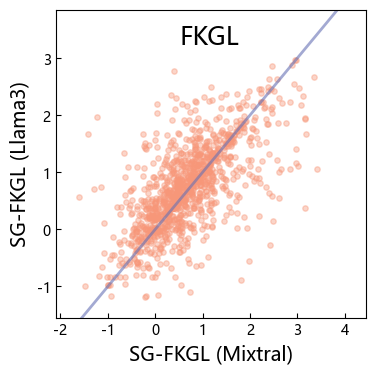

In [12]:
new_lat_vals, new_freq_vals, new_sgx_vals, new_sgy_vals = [], [], [], []
for i, (lat_value, freq_value, x_value, y_value) in enumerate(zip(lat_vals, freq_vals, sgx_vals, sgy_vals)):
    # if i > 1:
    #     break
    for lat, freq, x, y in zip(lat_value, freq_value, x_value, y_value):
        new_lat_vals.append(lat)
        new_freq_vals.append(freq)
        new_sgx_vals.append(x)
        new_sgy_vals.append(y)
    
lat_value = new_lat_vals
freq_value = new_freq_vals
x_value = new_sgx_vals
y_value = new_sgy_vals

# 计算全部的 Distance
distances_dict = {}
for lat, x, y in zip(lat_value, x_value, y_value):
    dis = distance_to_line(x, y)
    distances_dict[lat] = dis
dis_values = list(distances_dict.values())


# 根据字典的值进行排序，并构建新的有序字典
sorted_dict = {k: v for k, v in sorted(distances_dict.items(), key=lambda item: item[1])}
# print(sorted_dict)


# 查看单个词组在不同大模型之间的分差
colors = ['#f79779', '#6671b5']
print(len(dis_values), np.average(dis_values), np.median(dis_values))
fig, axs = plt.subplots(figsize=(4, 4))
plt.scatter(x_value, y_value, s=15, color=colors[0], alpha=0.4)
# 限制范围
def get_xy_lim(data):
    minu, maxi = 0, 0
    max_sign = math.copysign(1, max(data))
    min_sign = math.copysign(1, min(data))
    if max_sign > 0:
        maxi = max(data) * 1.3
    else:
        maxi = -1 * np.abs(max(data)) * 0.3
    if min_sign > 0:
        minu = min(data) * 0.3
    else:
        minu = -1 * np.abs(min(data)) * 1.3
    return minu, maxi

xminu, xmaxi = get_xy_lim( x_value) 
yminu, ymaxi = get_xy_lim( y_value)
plt.plot([xminu, xmaxi], [xminu, xmaxi], linewidth=2, color=colors[1], alpha=0.6)
plt.xlim(xminu, xmaxi)
plt.ylim(yminu, ymaxi)
plt.xlabel('SG-'+calculate_index+' ('+ modelx.title() +')', fontsize=14)
plt.ylabel('SG-'+calculate_index+' ('+ modely.title() +')', fontsize=14)

# plt.axvline(0, color='#58595b', linewidth=1.5, linestyle='--', alpha=0.8)
# plt.axhline(0, color='#58595b', linewidth=1.5, linestyle='--', alpha=0.8)
plt.text(xminu+(xmaxi-xminu)*0.4, yminu+(ymaxi-yminu)*0.95, calculate_index, fontsize=18, va='top')


Text(5e-06, 0.4464466321953182, '$Slope_{FKGL}$=-0.07')

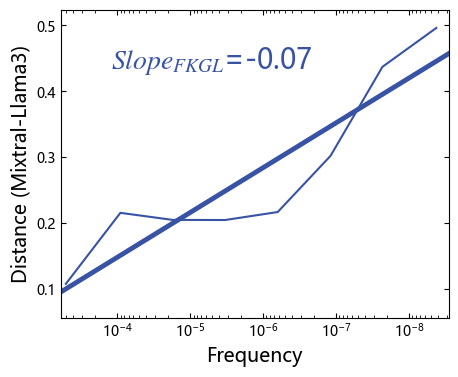

In [13]:
colors = ['#3853a4', '#f68c1e', '#b12425', '#f9bfcc', '#040707']
color = ''
for i, ele in enumerate(['FKGL', 'FRE', 'GFI', 'SMOG', 'CLI']):
    if calculate_index == ele:
        color = colors[i]

new_lat_vals, new_freq_vals, new_sgx_vals, new_sgy_vals = [], [], [], []
for i, (lat_value, freq_value, x_value, y_value) in enumerate(zip(lat_vals, freq_vals, sgx_vals, sgy_vals)):
    # if i > 1:
    #     break
    for lat, freq, x, y in zip(lat_value, freq_value, x_value, y_value):
        new_lat_vals.append(lat)
        new_freq_vals.append(freq)
        new_sgx_vals.append(x)
        new_sgy_vals.append(y)
    
lat_value = new_lat_vals
freq_value = new_freq_vals
x_value = new_sgx_vals
y_value = new_sgy_vals

distances = []
for x, y in zip(x_value, y_value):
    dis = distance_to_line(x, y)
    distances.append(dis)

x_freq, y_rate = [freq_value, distances]
# 使用等份（频率区间在X轴上相同）
number_of_bins = int(np.ceil(np.log(len(x_freq))))
# number_of_bins = 12
# print('词组数量:', len(x_freq), '分箱数量:', number_of_bins)

# 依据frequency进行分箱
freqs = x_freq
minu, maxi = np.min(freqs), np.max(freqs)
# print('最值:', minu, maxi)
# minu-minu*0.1: 扩大范围，确保所有的词组都能被包含在其中
bins = np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1)
# print('分箱边界:', bins)

# 计算数值
x_freq_bins, y_rate_bins = [], []
for i in range(number_of_bins):
    x_freq_bins.append([])
    y_rate_bins.append([])

for i, (bin_left, bin_right) in enumerate(zip(bins[:-1], bins[1:])):
    # print(bin_left, bin_right)
    for f, r in zip(x_freq, y_rate):
        if bin_left<=f and f<bin_right:
            x_freq_bins[i].append(f)
            y_rate_bins[i].append(r)

X, Y = [], []
error_bars = []
CIs = []
for x_, y_ in zip(x_freq_bins, y_rate_bins):
    if len(x_) == 0:
        continue
    X.append(get_center_value(x_))
    Y.append(np.average(y_))
    CIs.append(get_confidence_interval(y_, 0.95))

fig, ax = plt.subplots(figsize=(5, 4))
plt.xscale('log')
# 逆转 x 轴
plt.gca().invert_xaxis()

plt.plot(X, Y, color=color, linewidth=1.5, alpha=1)

# 绘制一条拟合直线
coeffs = np.polyfit(np.log10(X), Y, 1)
[slope, intercept] = coeffs
# print(slope, intercept)
slopex = [10**(np.log10(np.min(X))*1.1), 10**(np.log10(np.max(X))*0.9)]
slopey = [slope*np.log10(x)+intercept for x in slopex]
plt.plot(slopex, slopey, color=color, linewidth=3.5, alpha=1)
# plt.xlim(10**(np.log10(np.min(X))*1.02), 10**(np.log10(np.max(X))*0.98))
plt.xlim(10**(np.log10(np.max(X))*0.98), 10**(np.log10(np.min(X))*1.02))

plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Distance'+' ('+ modelx.title()+ '-' +modely.title() +')', fontsize=14)

plt.tick_params(top='on', right='on', which='both')
plt.text(5e-6, np.max(Y)*0.9, r'$Slope_{'+f'{calculate_index}'+'}$'+f'={slope:.2f}', fontsize=20, ha='center', va='center', color=color)

#### 汇总图例

In [14]:
# 每一组数据保存为 (lat, freq, sgx, sgy), 其中sgx为modelx模型的score gap
def get_scoregap_bins_values(modelx, modely, index):
    # file_path_x = 'data\llm\sbert\score-gap\LE-dataset v2.0-150-'+ modelx +'-score-gap v1.1.json'
    # file_path_y = 'data\llm\sbert\score-gap\LE-dataset v2.0-150-'+ modely +'-score-gap v1.1.json'
    
    file_path_x = 'data/llm2.1.2/sbert/score-gap/LE-dataset v2.0-150-'+ modelx +'-score-gap v2.1.2.json'
    file_path_y = 'data/llm2.1.2/sbert/score-gap/LE-dataset v2.0-150-'+ modely +'-score-gap v2.1.2.json'
    
    score_gap_modelx = get_score_gap(file_path_x, index)
    sgx_deviation = clean_deviation(score_gap_modelx)
    score_gap_modely = get_score_gap(file_path_y, index)
    sgy_deviation = clean_deviation(score_gap_modely)
    dict_frequency = get_frequency_in_C4EL()
    
    elements = []
    for i, (lat, sgx) in enumerate(sgx_deviation.items()):
        if lat in sgy_deviation:
            sgy = sgy_deviation[lat]
            freq = dict_frequency[lat]
            elements.append((lat, freq, sgx, sgy))

    freqs = []
    for ele in elements:
        lat, freq, sgx, sgy = ele
        freqs.append(freq)
    # 使用等份（频率区间在X轴上相同）
    number_of_bins = int(np.ceil(np.log(len(freqs))))
    # 依据frequency进行分箱
    minu, maxi = np.min(freqs), np.max(freqs)
    # print('最值:', minu, maxi)
    # minu-minu*0.1: 扩大范围，确保所有的词组都能被包含在其中
    bins = list(np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1))
    bins.reverse()
    # print('分箱边界:', bins)

    # 将所有的数据进行分箱处理
    lat_vals, freq_vals, sgx_vals, sgy_vals = [], [], [], []
    for i, (bin_left, bin_right) in enumerate(zip(bins[1:], bins[:-1])):
        # print(bin_left, bin_right)
        lats, freqs, sgxs, sgys = [], [], [], []
        for ele in elements:
            lat, freq, sgx, sgy = ele
            if bin_left<=freq and freq<bin_right:
                lats.append(lat)
                freqs.append(freq)
                # 获取sgo sgm
                sgxs.append(sgx)
                sgys.append(sgy)
        lat_vals.append(lats)
        freq_vals.append(freqs)
        sgx_vals.append(sgxs)
        sgy_vals.append(sgys)
        
    return lat_vals, freq_vals, sgx_vals, sgy_vals


# 将bins中的数据汇总
def get_all_from_bins(modelx, modely, index):
    lat_vals, freq_vals, sgx_vals, sgy_vals = get_scoregap_bins_values(modelx, modely, index)
    new_lat_vals, new_freq_vals, new_sgx_vals, new_sgy_vals = [], [], [], []
    for lat_value, freq_value, x_value, y_value in zip(lat_vals, freq_vals, sgx_vals, sgy_vals):
        for lat, freq, x, y in zip(lat_value, freq_value, x_value, y_value):
            new_lat_vals.append(lat)
            new_freq_vals.append(freq)
            new_sgx_vals.append(x)
            new_sgy_vals.append(y)
    lat_value = new_lat_vals
    freq_value = new_freq_vals
    x_value = new_sgx_vals
    y_value = new_sgy_vals
    return lat_value, freq_value, x_value, y_value


In [15]:
# 限制范围
def get_xy_lim(data):
    minu, maxi = 0, 0
    max_sign = math.copysign(1, max(data))
    min_sign = math.copysign(1, min(data))
    if max_sign > 0:
        maxi = max(data) * 1.3
    else:
        maxi = -1 * np.abs(max(data)) * 0.3
    if min_sign > 0:
        minu = min(data) * 0.3
    else:
        minu = -1 * np.abs(min(data)) * 1.3
    return minu, maxi


def plotSubpanelAInner(ax, x_value, y_value, index, color):
    # colors = ['#f79779', '#6671b5']
    ax.scatter(x_value, y_value, s=20, color=color, alpha=0.3)

    xminu, xmaxi = get_xy_lim( x_value) 
    yminu, ymaxi = get_xy_lim( y_value)
    ax.plot([xminu, xmaxi], [xminu, xmaxi], linewidth=2, color=color, alpha=1)
    ax.set_xlim(xminu, xmaxi)
    ax.set_ylim(yminu, ymaxi)
    # ax.set_xlabel('Score gap'+' ('+ modelx.title() +')', fontsize=14)
    # ax.set_ylabel('Score gap'+' ('+ modely.title() +')', fontsize=14)
    ax.tick_params(axis='x', labelsize=14) 
    ax.tick_params(axis='y', labelsize=14)    

    # plt.axvline(0, color='#58595b', linewidth=1.5, linestyle='--', alpha=0.8)
    # plt.axhline(0, color='#58595b', linewidth=1.5, linestyle='--', alpha=0.8)
    ax.text(xminu+(xmaxi-xminu)*0.1, yminu+(ymaxi-yminu)*0.95, index, fontsize=18, va='top', color=color)
    ax.tick_params(top='on', right='on', which='both')

In [16]:
def plotSubpanelBInner(ax, x_value, y_value, index, color):
    lat_value, freq_value, x_value, y_value = get_all_from_bins(modelx, modely, index)
    distances = []
    for x, y in zip(x_value, y_value):
        dis = distance_to_line(x, y)
        distances.append(dis)

    x_freq, y_rate = [freq_value, distances]
    # 使用等份（频率区间在X轴上相同）
    number_of_bins = int(np.ceil(np.log(len(x_freq))))
    freqs = x_freq
    minu, maxi = np.min(freqs), np.max(freqs)
    bins = np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1)

    # 计算数值
    x_freq_bins, y_rate_bins = [], []
    for i in range(number_of_bins):
        x_freq_bins.append([])
        y_rate_bins.append([])

    for i, (bin_left, bin_right) in enumerate(zip(bins[:-1], bins[1:])):
        # print(bin_left, bin_right)
        for f, r in zip(x_freq, y_rate):
            if bin_left<=f and f<bin_right:
                x_freq_bins[i].append(f)
                y_rate_bins[i].append(r)

    X, Y = [], []
    for x_, y_ in zip(x_freq_bins, y_rate_bins):
        if len(x_) == 0:
            continue
        X.append(get_center_value(x_))
        Y.append(np.average(y_))


    ax.set_xscale('log')
    ax.invert_xaxis()

    ax.plot(X, Y, color=color, linewidth=1.5, alpha=0.8)

    # 绘制一条拟合直线
    coeffs = np.polyfit(np.log10(X), Y, 1)
    [slope, intercept] = coeffs
    # print(slope, intercept)
    slopex = [10**(np.log10(np.min(X))*1.1), 10**(np.log10(np.max(X))*0.9)]
    slopey = [slope*np.log10(x)+intercept for x in slopex]
    ax.plot(slopex, slopey, color=color, linewidth=3, alpha=0.8)
    ax.set_xlim(10**(np.log10(np.max(X))*0.98), 10**(np.log10(np.min(X))*1.02))

    # ax.set_xlabel('Frequency (log)', fontsize=14)
    # ax.set_ylabel('Distance'+' ('+ modelx.title()+ '-' +modely.title() +')', fontsize=14)
    ax.tick_params(axis='x', labelsize=14) 
    ax.tick_params(axis='y', labelsize=14)  

    ax.tick_params(top='on', right='on', which='both')
    ax.text(5e-6, np.max(Y)*0.9, r'$Slope_{'+f'{index}'+'}$'+f'={slope:.2f}', fontsize=18, ha='center', va='center', color=color)
    
    # 返回散点和拟合线的数据
    return [X, Y, slope, intercept]
    

In [18]:
# 删除边框和标签
def delBorder(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

Text(0.048, 0.635, 'b')

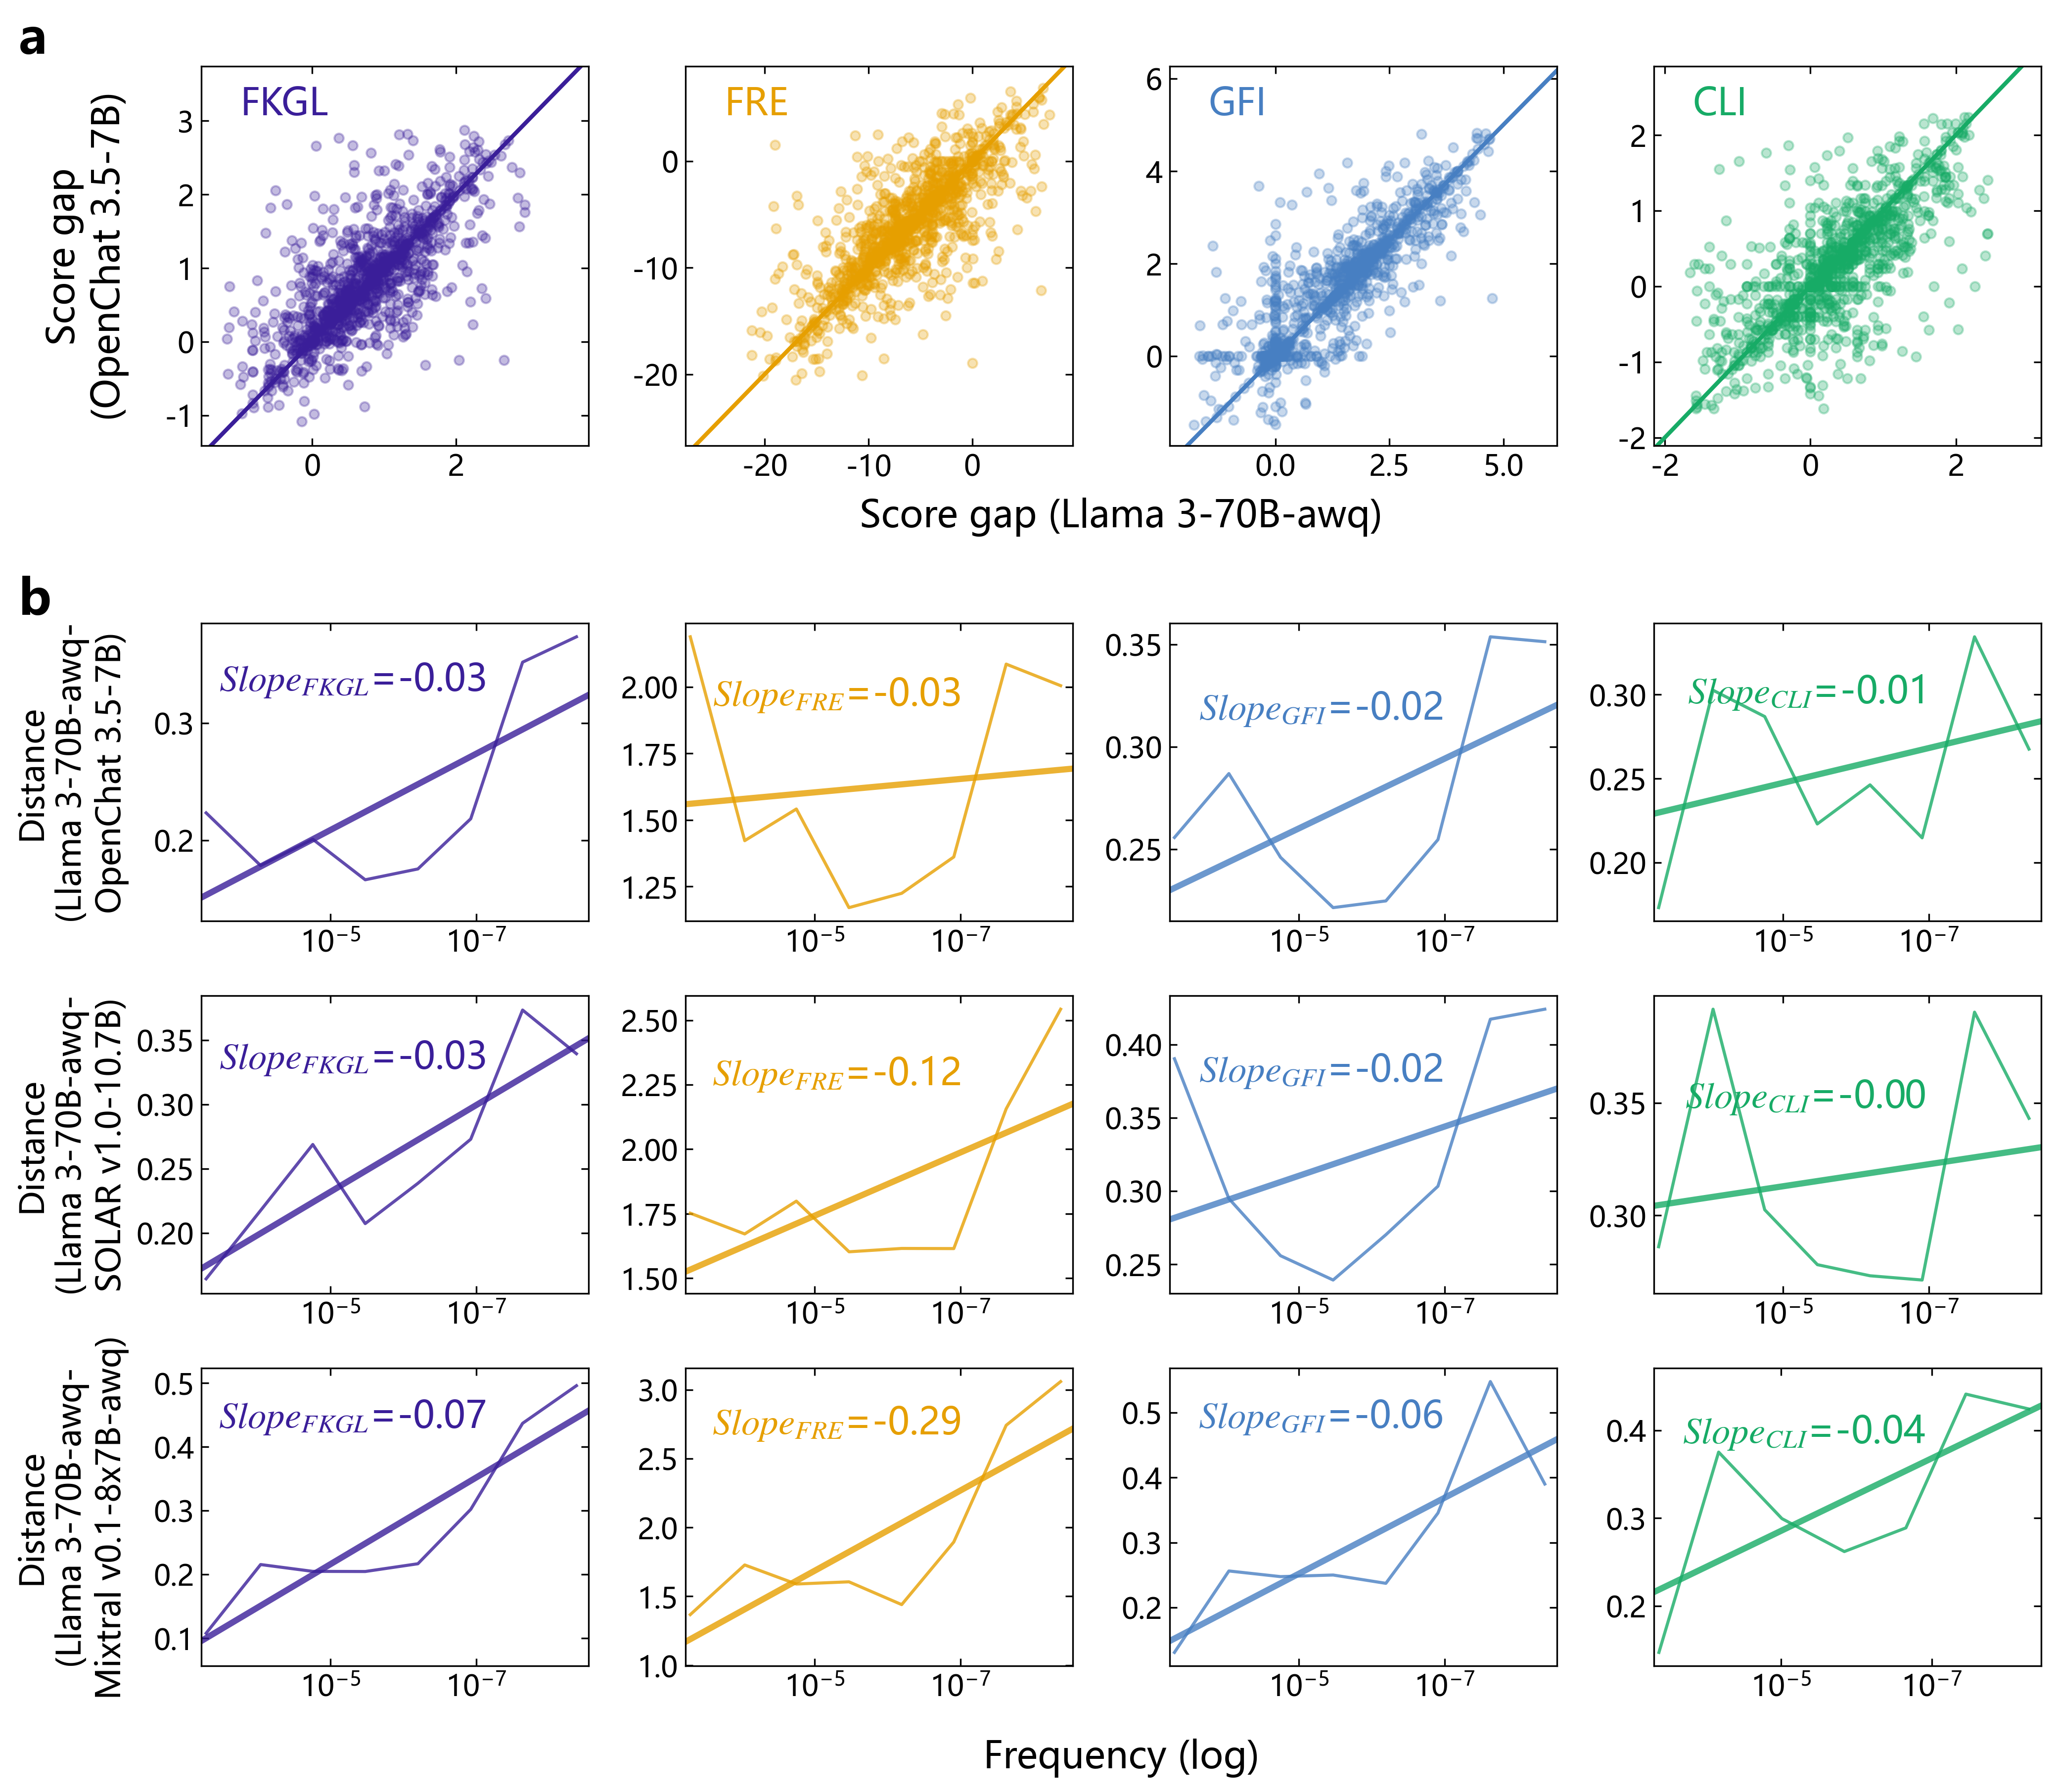

In [20]:
plt.rcParams['figure.dpi'] = 300
fig, axs_total = plt.subplots(2, 1, figsize=(16, 14), gridspec_kw={'height_ratios': [4, 11]})

# 创建子图 A
axs_A = axs_total[0]
inner_grids_A = axs_A.get_subplotspec().subgridspec(1, 4)
axs_A1 = fig.add_subplot(inner_grids_A[0, 0])
axs_A2 = fig.add_subplot(inner_grids_A[0, 1])
axs_A3 = fig.add_subplot(inner_grids_A[0, 2])
axs_A4 = fig.add_subplot(inner_grids_A[0, 3])
axAs = [axs_A1, axs_A2, axs_A3, axs_A4]
delBorder(axs_A)

modelx, modely = 'llama3', 'openchat'
indexs = ['FKGL', 'FRE', 'GFI', 'CLI']
colors = ['#3a1e99', '#e69f00', '#477fc2', '#17ab66']
# 绘制 A图
for index, axa, col in zip(indexs, axAs, colors):
    lat_value, freq_value, x_value, y_value = get_all_from_bins(modelx, modely, index)
    plotSubpanelAInner(axa, x_value, y_value, index, col)
# 设置坐标
axs_A.set_xlabel('Score gap' + ' (Llama 3-70B-awq)', fontsize=18, labelpad=25)
axs_A.set_ylabel('Score gap' + '\n(OpenChat 3.5-7B)', fontsize=18, labelpad=35)
fig.subplots_adjust(wspace=0.25, hspace=0.25)

# 创建子图 B
axs_B = axs_total[1]
inner_grids_B = axs_B.get_subplotspec().subgridspec(3, 1)
axs_B1 = fig.add_subplot(inner_grids_B[0, 0])
axs_B2 = fig.add_subplot(inner_grids_B[1, 0])
axs_B3 = fig.add_subplot(inner_grids_B[2, 0])
delBorder(axs_B)

# 创建子图 B 的第 1 行子图 
inner_grids_B1 = axs_B1.get_subplotspec().subgridspec(1, 4)
axs_B11 = fig.add_subplot(inner_grids_B1[0, 0])
axs_B12 = fig.add_subplot(inner_grids_B1[0, 1])
axs_B13 = fig.add_subplot(inner_grids_B1[0, 2])
axs_B14 = fig.add_subplot(inner_grids_B1[0, 3])
axB1s = [axs_B11, axs_B12, axs_B13, axs_B14]
delBorder(axs_B1)

# 创建子图 B 的第 2 行子图 
inner_grids_B2 = axs_B2.get_subplotspec().subgridspec(1, 4)
axs_B21 = fig.add_subplot(inner_grids_B2[0, 0])
axs_B22 = fig.add_subplot(inner_grids_B2[0, 1])
axs_B23 = fig.add_subplot(inner_grids_B2[0, 2])
axs_B24 = fig.add_subplot(inner_grids_B2[0, 3])
axB2s = [axs_B21, axs_B22, axs_B23, axs_B24]
delBorder(axs_B2)

# 创建子图 B 的第 3 行子图 
inner_grids_B3 = axs_B3.get_subplotspec().subgridspec(1, 4)
axs_B31 = fig.add_subplot(inner_grids_B3[0, 0])
axs_B32 = fig.add_subplot(inner_grids_B3[0, 1])
axs_B33 = fig.add_subplot(inner_grids_B3[0, 2])
axs_B34 = fig.add_subplot(inner_grids_B3[0, 3])
axB3s = [axs_B31, axs_B32, axs_B33, axs_B34]
delBorder(axs_B3)

# 绘制子图 B
modelx = 'llama3'
modelx_label = 'Llama 3-70B-awq'
modelys_label = ['OpenChat 3.5-7B', 'SOLAR v1.0-10.7B', 'Mixtral v0.1-8x7B-awq']
indexs = ['FKGL', 'FRE', 'GFI', 'CLI']
colors = ['#3a1e99', '#e69f00', '#477fc2', '#17ab66']
axB_objs = [axs_B1, axs_B2, axs_B3]
AXBS = [axB1s, axB2s, axB3s]

model_data_all = [] # 保存所有模型的散点和拟合线数据
for i, (modely, axBs, axB_obj) in enumerate(zip(['openchat', 'solar', 'mixtral'], AXBS, axB_objs)):
    model_data_inner = [] # 保存两个模型的散点和拟合线数据
    for index, axb, col in zip(indexs, axBs, colors):
        lat_value, freq_value, x_value, y_value = get_all_from_bins(modelx, modely, index)
        X, Y, slope, intercept = plotSubpanelBInner(axb, x_value, y_value, index, col)
        model_data_inner.append([X, Y, slope, intercept])
    axB_obj.set_ylabel('Distance\n' + '('+modelx_label+'-\n'+ modelys_label[i] +')', fontsize=16, labelpad=35)
    model_data_all.append(model_data_inner)
# 设置坐标
axs_B.set_xlabel('Frequency (log)', fontsize=18, labelpad=35)
#  添加字母
fig.text(0.048, 0.905, 'a', fontsize=24, va='top', fontweight='bold')
fig.text(0.048, 0.635, 'b', fontsize=24, va='top', fontweight='bold')

#### C4EL as a benchmark

In [21]:
# 获取两个模型在对应的index下的偏离数据
def get_model_detail_data(x_value, y_value, index):
    lat_value, freq_value, x_value, y_value = get_all_from_bins(modelx, modely, index)
    distances = []
    for x, y in zip(x_value, y_value):
        dis = distance_to_line(x, y)
        distances.append(dis)

    x_freq, y_rate = [freq_value, distances]
    # 使用等份（频率区间在X轴上相同）
    number_of_bins = int(np.ceil(np.log(len(x_freq))))
    freqs = x_freq
    minu, maxi = np.min(freqs), np.max(freqs)
    bins = np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1)

    # 计算数值
    x_freq_bins, y_rate_bins = [], []
    for i in range(number_of_bins):
        x_freq_bins.append([])
        y_rate_bins.append([])

    for i, (bin_left, bin_right) in enumerate(zip(bins[:-1], bins[1:])):
        # print(bin_left, bin_right)
        for f, r in zip(x_freq, y_rate):
            if bin_left<=f and f<bin_right:
                x_freq_bins[i].append(f)
                y_rate_bins[i].append(r)

    X, Y = [], []
    for x_, y_ in zip(x_freq_bins, y_rate_bins):
        if len(x_) == 0:
            continue
        X.append(get_center_value(x_))
        Y.append(np.average(y_))

    # 绘制一条拟合直线
    coeffs = np.polyfit(np.log10(X), Y, 1)
    [slope, intercept] = coeffs
    # print(slope, intercept)
    slopex = [10**(np.log10(np.min(X))*1.1), 10**(np.log10(np.max(X))*0.9)]
    slopey = [slope*np.log10(x)+intercept for x in slopex]
    # 返回散点和拟合线的数据
    return [distances, X, Y, slope, intercept]


# 计算在x轴为对数坐标下的垂直距离
def calculate_distacne(point_x, point_y, a, b):
    return np.fabs(a*np.log10(point_x)-point_y+b) / np.sqrt(a*a+1)


# 获取基准的数值
def get_value(distances, X, Y, slope, intercept):
    distances = []
    for x, y in zip(X, Y):
        dis = calculate_distacne(x, y, slope, intercept)
        distances.append(dis)

    # 数值转换，将数据转换成指数函数 y= math.exp(-x)
    # return np.average(distances), math.exp(-np.average(distances))*100
    return np.sum(distances), 100*math.exp(-np.sum(distances))

In [22]:
models = ['mistral v0.1', 'mistral v0.2', 'mistral v0.3', 'openchat', 'llama3.1', 'solar', 'mixtral', 'llama3']

indexs = ['FKGL', 'FRE', 'GFI', 'CLI']

for modelx in models:
    # modelys = [item for item in models if item != modelx]
    modely = models

    model_dict = {}
    for index in indexs:
        # if index != 'FKGL':
        #     continue
        index_dict = {}
        print('--------------------'+ index +'---------------------')
        for modely in models:
            distances, X, Y, slope, intercept = get_model_detail_data(modelx, modely, index)
            de_value, value = get_value(distances, X, Y, slope, intercept)
            print(modely, round(value, 2))    
            index_dict[modely] = value
        model_dict[index] = index_dict
    # print(model_dict)

    with open('./data/llm2.1.2/sbert/score-gap/hotmap/'+modelx+'.json', 'w') as file:
        json.dump(model_dict, file, indent=2)
    file.close()

--------------------FKGL---------------------
mistral v0.1 100.0
mistral v0.2 58.14
mistral v0.3 63.28
openchat 65.82
llama3.1 56.09
solar 55.35
mixtral 62.57
llama3 63.7
--------------------FRE---------------------
mistral v0.1 100.0
mistral v0.2 7.26
mistral v0.3 10.0
openchat 9.48
llama3.1 7.86
solar 2.64
mixtral 3.52
llama3 6.3
--------------------GFI---------------------
mistral v0.1 100.0
mistral v0.2 65.92
mistral v0.3 60.37
openchat 70.53
llama3.1 68.67
solar 57.49
mixtral 67.26
llama3 77.07
--------------------CLI---------------------
mistral v0.1 100.0
mistral v0.2 76.02
mistral v0.3 68.66
openchat 68.66
llama3.1 75.53
solar 69.75
mixtral 71.0
llama3 73.51
--------------------FKGL---------------------
mistral v0.1 58.14
mistral v0.2 100.0
mistral v0.3 59.85
openchat 67.57
llama3.1 67.17
solar 68.83
mixtral 51.12
llama3 62.56
--------------------FRE---------------------
mistral v0.1 7.26
mistral v0.2 100.0
mistral v0.3 5.04
openchat 7.99
llama3.1 16.45
solar 4.72
mixtral 2.4
l

#### 绘制热力图

C:\Users\leisaihua\AppData\Local\Temp\ipykernel_2012\3872721249.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels([str(ele) for ele in range(0, 100, 10)], fontstyle='italic', fontsize=10, rotation=45)


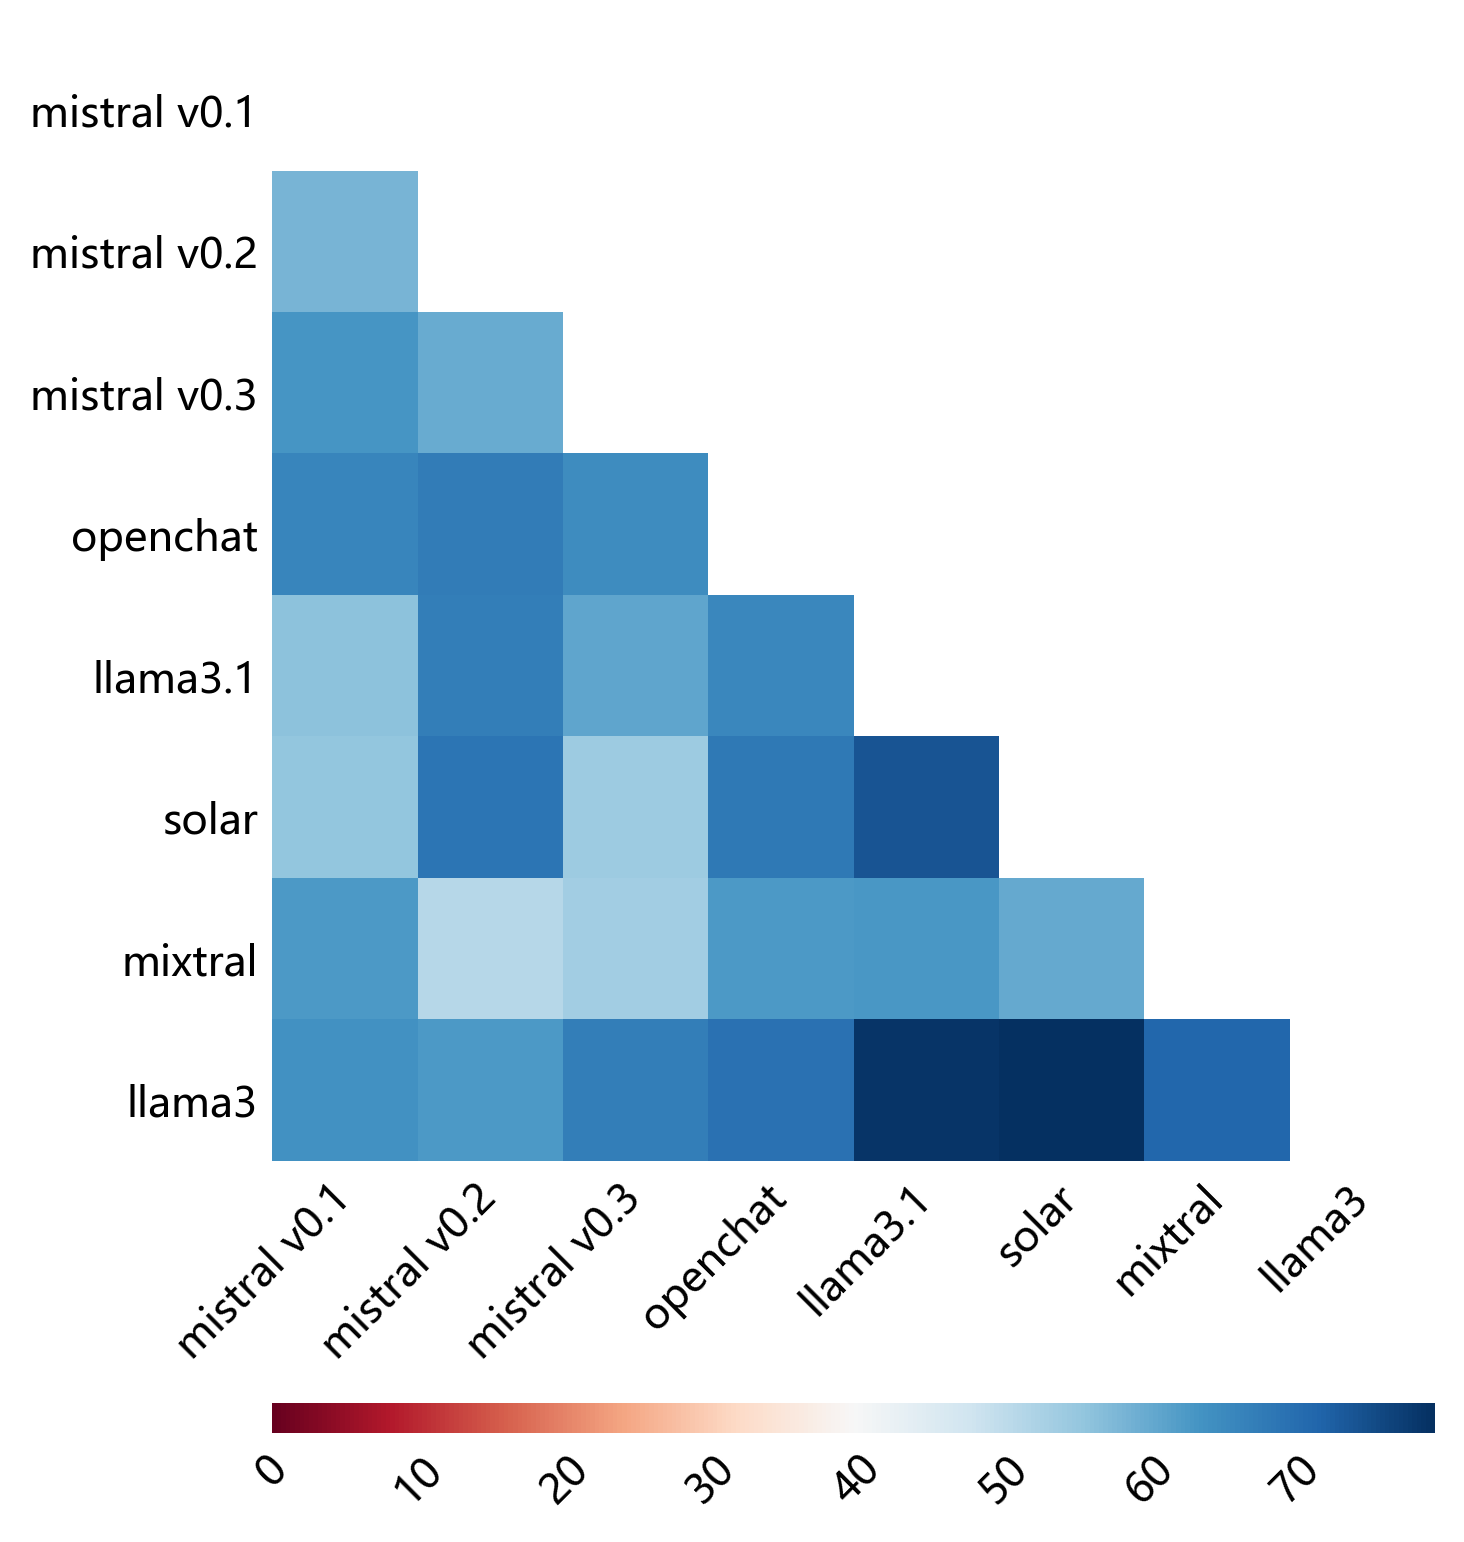

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams['figure.dpi'] = 300

models = ['mistral v0.1', 'mistral v0.2', 'mistral v0.3', 'openchat', 'llama3.1', 'solar', 'mixtral', 'llama3']

data = []
for modelx in models:
    with open('./data/llm2.1.2/sbert/score-gap/hotmap/'+modelx+'.json', 'r') as file:
        model_bench = json.load(file)
        infos = list(model_bench['FKGL'].values())
        data.append(infos)
    file.close()
    
# print(data)
# print(data)
data_array = np.array(data)
# print(data_array)

fig, ax = plt.subplots(figsize=(5, 7))
mask = np.triu(np.ones_like(data_array, dtype=bool))
# 使用Seaborn创建热力图
maxi = np.sort(np.unique(data_array.flatten()))[-2]
vmin, vmax = 0, maxi
heatmap = sns.heatmap(data_array, ax=ax, annot=False, mask=mask, cmap='RdBu', fmt=".0f", vmin=vmin, vmax=vmax, cbar_kws={"orientation": "horizontal",  # 将刻度条放在下方
                    "shrink": 1,  # 缩短刻度条的长度
                    "aspect": 40,  # 增加刻度条的宽度
                    })

ticks = []
for i in range(len(data_array)):
    ticks.append(i+0.6)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(models, fontstyle='italic', rotation=45, ha='right')
ax.set_yticklabels(models, fontstyle='italic', rotation=0, ha='right')
ax.tick_params(length=0)


# 设置刻度条标签格式
cbar = heatmap.collections[0].colorbar
cbar.ax.set_xticklabels([str(ele) for ele in range(0, 100, 10)], fontstyle='italic', fontsize=10, rotation=45)
cbar.ax.tick_params(length=0)

#### 汇总图例

Text(0.532, 0.49, 'd')

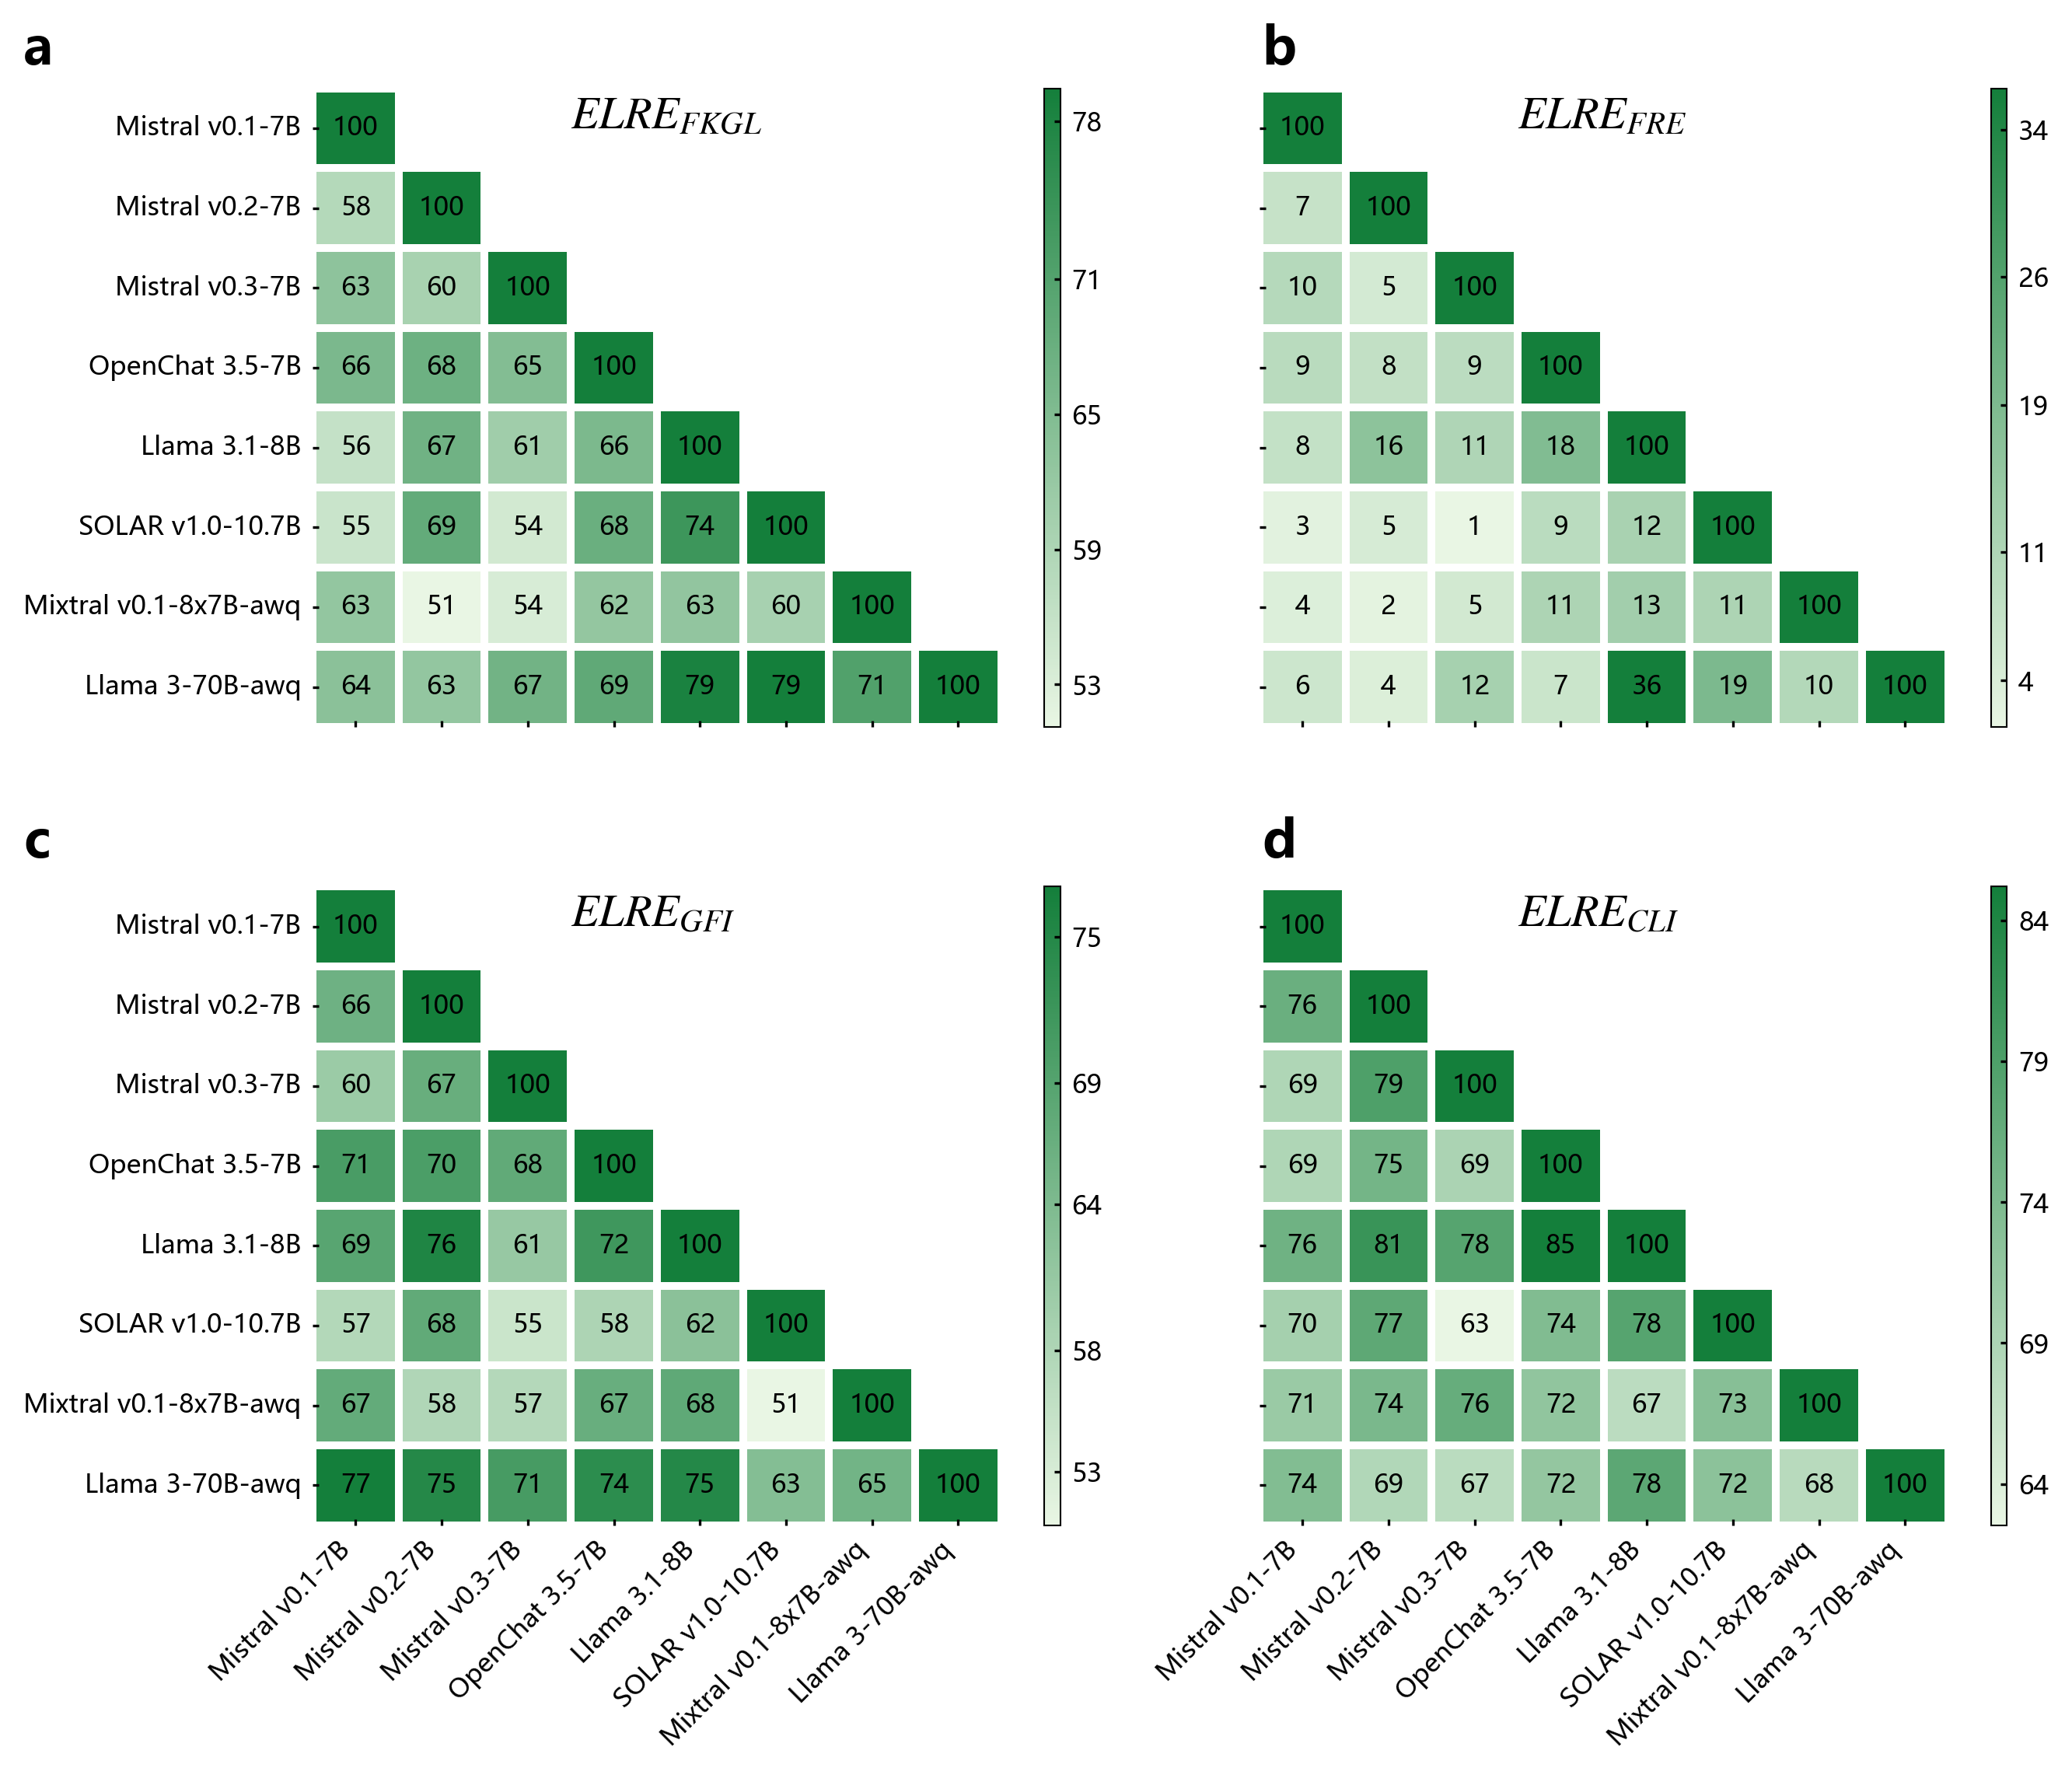

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings


# 忽略所有警告
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
# 将X/Y轴的刻度线方向设置向内

def plotSubpanel(ax, index, root_apth, axis, ayis):
    models = ['mistral v0.1', 'mistral v0.2', 'mistral v0.3', 'openchat', 'llama3.1', 'solar', 'mixtral', 'llama3']
    models_label = ['Mistral v0.1-7B', 'Mistral v0.2-7B', 'Mistral v0.3-7B', 'OpenChat 3.5-7B', 'Llama 3.1-8B', 'SOLAR v1.0-10.7B', 'Mixtral v0.1-8x7B-awq', 'Llama 3-70B-awq']

    data = []
    for modelx in models:
        with open(root_apth+modelx+'.json', 'r') as file:
            model_bench = json.load(file)
            infos = list(model_bench[index].values())
            data.append(infos)
        file.close()
        
    data_array = np.array(data)
    minu = np.sort(np.unique(data_array.flatten()))[0]
    maxi = np.sort(np.unique(data_array.flatten()))[-2]
    # print(maxi)
    # mask = np.triu(np.ones_like(data_array, dtype=bool))
    mask = np.tri(data_array.shape[0], k=-1).T
    # 使用Seaborn创建热力图
    val = 0
    vmin, vmax = minu*(1-val), maxi*(1+val)
    # vmin, vmax = 0, 100
    
    # 定义一个自定义的渐变色
    deep_cmap = LinearSegmentedColormap.from_list('deep_blue_cmap', ['#e9f6e4', '#147f3b'])
    color = deep_cmap
    heatmap = sns.heatmap(data_array, 
                          ax=ax, 
                          annot=True, 
                          mask=mask, 
                          linewidths=2, 
                          annot_kws={"color": "black", "fontsize": "8"}, 
                          cmap=color, 
                          fmt=".0f", 
                          vmin=vmin, vmax=vmax, 
                          cbar_kws={
                      "shrink": 1,  # 缩短刻度条的长度
                      "aspect": 40,  # 增加刻度条的宽度
                     })
    # 设置刻度条标签格式
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8, length=2)
    cbar.set_ticks(np.linspace(np.ceil(vmin+(vmax-vmin)*0.05), np.floor(vmax-(vmax-vmin)*0.05), 5).astype(int))  # 自定义刻度的位置
    # 设置刻度条的边框
    cbar.outline.set_linewidth(0.5)  # 设置colorbar的边框宽度
    cbar.outline.set_edgecolor('black')  # 设置colorbar的边框颜色
    
    ax.set_aspect('auto')
    
    ticks = []
    for i in range(len(data_array)):
        ticks.append(i+0.5)
    
    if axis == 1:
        ax.set_xticks(ticks)
        ax.set_xticklabels(models_label, fontstyle='italic', rotation=45, ha='right')
    else:
        ax.set_xticklabels([])
    if ayis == 1:
        ax.set_yticks(ticks)
        ax.set_yticklabels(models_label, fontstyle='italic', rotation=0, ha='right')
    else:
        ax.set_yticklabels([])
        
    ax.tick_params(length=2)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.text(3, 0.5, r'$ELRE_{'+ f'{index}' +'}$', fontsize=14)
    
    
    
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

indexs = ['FKGL', 'FRE', 'GFI', 'CLI']
root_path = './data/llm2.1.2/sbert/score-gap/hotmap/'

for i, index in enumerate(indexs):
    axis, ayis = 0, 0
    if i in [2, 3]:
        axis = 1
    if i in [0, 2]:
        ayis = 1
    plotSubpanel(axs[i], index, root_path, axis=axis, ayis=ayis)
fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.text(0.001, 0.915, 'a', fontsize=16, va='top', fontweight='bold')
fig.text(0.532, 0.915, 'b', fontsize=16, va='top', fontweight='bold')
fig.text(0.001, 0.490, 'c', fontsize=16, va='top', fontweight='bold')
fig.text(0.532, 0.490, 'd', fontsize=16, va='top', fontweight='bold')